In [1]:
import numpy as np
import pandas as pd

In [2]:
filepath ='./stock_data/FB.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-23,182.500000,186.910004,182.179993,186.899994,186.899994,16628100
1,2018-05-24,185.880005,186.800003,185.029999,185.929993,185.929993,12354700
2,2018-05-25,186.020004,186.330002,184.449997,184.919998,184.919998,10965100
3,2018-05-29,184.339996,186.809998,183.710007,185.740005,185.740005,16398900
4,2018-05-30,186.539993,188.000000,185.250000,187.669998,187.669998,13736900


In [3]:
data.shape

(252, 7)

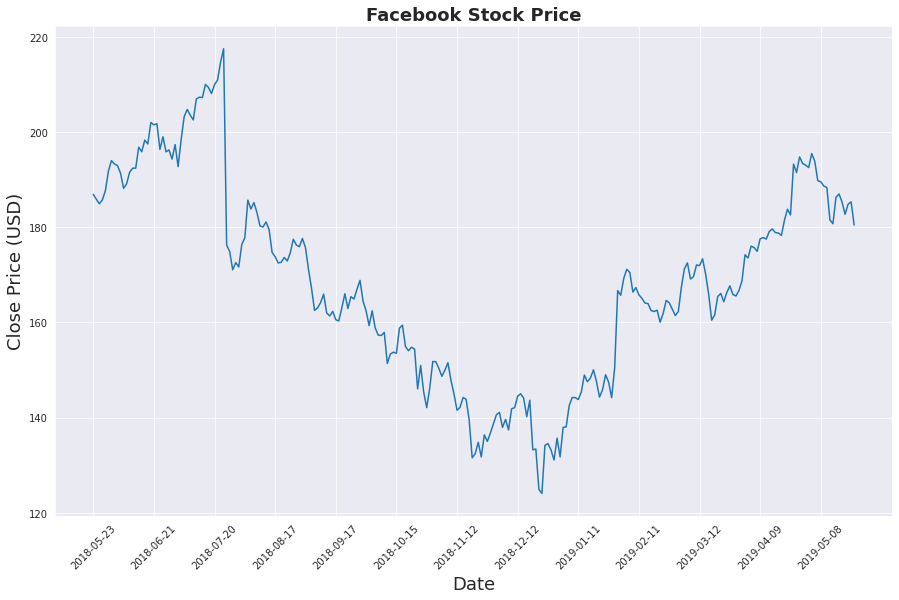

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.figure(figsize=(15, 9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],20), data['Date'].loc[::20], rotation=45)
plt.title('Facebook Stock Price', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.show()

### 1. Feature Engineering

In [5]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [6]:
from sklearn.preprocessing import MinMaxScaler

# To make every feature have the same influence and to prevent vanishing gradient or gradient explosion problem during training.
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/tmp/ipykernel_7935/4118617483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [7]:
price['Close'], price['Close'].shape

(0      0.345034
 1      0.324272
 2      0.302654
 3      0.320206
 4      0.361515
          ...   
 247    0.310788
 248    0.255565
 249    0.300514
 250    0.311216
 251    0.207192
 Name: Close, Length: 252, dtype: float64,
 (252,))

### 2. Dataset 

In [8]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []

    # You can free play (seq_length)
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1, :]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

In [9]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape', x_train.shape)
print('y_train.shape', y_train.shape)
print('x_test.shape', x_test.shape)
print('y_test.shape', y_test.shape)

x_train.shape (186, 19, 1)
y_train.shape (186, 1)
x_test.shape (46, 19, 1)
y_test.shape (46, 1)


### 3. Model Construction

##### Note: torch.nn.LSTM input shape = (seq_length, batch_size, input_size)
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [10]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [11]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim)).requires_grad_()
        c0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim)).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [13]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### 4. Model Training

In [14]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for i in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print('Epoch', i, 'MSE', loss.item())
    hist[i] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time = time.time() - start_time
print('Training time: {}'.format(training_time))

Epoch 0 MSE 0.20349083840847015
Epoch 1 MSE 0.19171622395515442
Epoch 2 MSE 0.16328664124011993
Epoch 3 MSE 0.13338162004947662
Epoch 4 MSE 0.07290306687355042
Epoch 5 MSE 0.04354086145758629
Epoch 6 MSE 0.1120809018611908
Epoch 7 MSE 0.04571673274040222
Epoch 8 MSE 0.03301410749554634
Epoch 9 MSE 0.04437924548983574
Epoch 10 MSE 0.053927574306726456
Epoch 11 MSE 0.05687860772013664
Epoch 12 MSE 0.0528375618159771
Epoch 13 MSE 0.04329894855618477
Epoch 14 MSE 0.03246413171291351
Epoch 15 MSE 0.027074096724390984
Epoch 16 MSE 0.029882390052080154
Epoch 17 MSE 0.03366832807660103
Epoch 18 MSE 0.03522665426135063
Epoch 19 MSE 0.033836670219898224
Epoch 20 MSE 0.028385406360030174
Epoch 21 MSE 0.023968514055013657
Epoch 22 MSE 0.02371392399072647
Epoch 23 MSE 0.02560906484723091
Epoch 24 MSE 0.02680196799337864
Epoch 25 MSE 0.02646646276116371
Epoch 26 MSE 0.025248758494853973
Epoch 27 MSE 0.023891957476735115
Epoch 28 MSE 0.0226576067507267
Epoch 29 MSE 0.021632706746459007
Epoch 30 MSE 0

### 5. Results Visualization

In [15]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

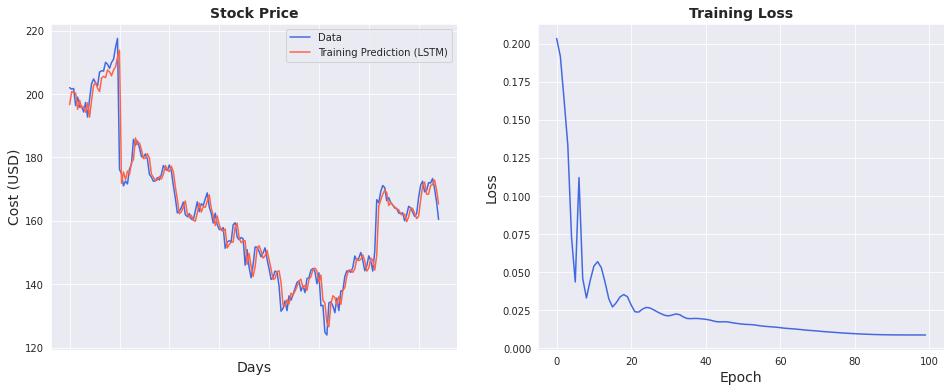

In [16]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock Price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

### 6. Model Evaluation

In [17]:
x_test[-1]

tensor([[0.4812],
        [0.4433],
        [0.5137],
        [0.4842],
        [0.4762],
        [0.4655],
        [0.5285],
        [0.4944],
        [0.4065],
        [0.4015],
        [0.3825],
        [0.3759],
        [0.2303],
        [0.2130],
        [0.3315],
        [0.3470],
        [0.3108],
        [0.2556],
        [0.3005]])

In [18]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate the root mean squared error
train_score = np.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % train_score)
test_score = np.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % test_score)
lstm.append(train_score)
lstm.append(test_score)
lstm.append(training_time)

Train Score: 4.36 RMSE
Test Score: 2.91 RMSE


In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [21]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed